In [2]:
import os
import numpy as np
#Suppress Warning
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.layers import GRU, LSTM, Input, Dense, Layer, BatchNormalization, TimeDistributed, ConvLSTM2D, BatchNormalization, Conv2D, Flatten
from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import losses

In [3]:
class LSTM_GRU_Layer(Layer):
    def __init__(self, LSTM_units, GRU_units, not_last_layer):     
        super().__init__()
        self.LSTM_layer = LSTM(units=LSTM_units,return_sequences = True, return_state = True, recurrent_dropout = 0.1)
        self.GRU_layer = GRU(units = GRU_units, return_sequences= not_last_layer)
        self.gru_units = GRU_units
        self.lstm_units = LSTM_units
        self.last_layer = not_last_layer
        self.dense_tranfer = Dense(units = GRU_units, activation= "relu")
    
    def build(self, input_shape):
        self.t = input_shape[1]
        self.n = input_shape[2]
        if not self.last_layer:   # final layer
            self.dense_out = Dense(1)  # (B, N)
        else:
            self.dense_out = TimeDistributed(Dense(self.n))
        
    def call(self, inputs):
        #input dimension (batch, time_steps, num_features)
        out, _, c = self.LSTM_layer(inputs)
        # output have dimesion (time_steps, lstm_units)
        # Dense change lstm units to gru units
        c = self.dense_tranfer(c)
        # Cell state of LSTM plug in to Hidden State of GRU
        out = self.GRU_layer(out, initial_state = c)
        # Make output equal same dimension of inputs
        # If we stack them together, out is (time_steps, num_features)
        out = self.dense_out(out) 

        return out

In [4]:
df = pd.read_csv('compiled_dataset.csv', parse_dates=['Date'])

features = [
    "Date",
    'dow_jones_adj_close_price',
    'nasdaq_adj_close_price',
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'treasury_1_year_rate',
    'breakeven_inflation_5_year_rate',
    'bank_prime_loan_rate',
    'federal_funds_rate',
]

target = 'cushing_crude_oil_price'

data = df[features + [target]]
y = df[target]
#print(data)
data.set_index("Date", inplace= True)
data = data.resample('D').mean()
data = data.interpolate()

In [5]:
features.remove("Date")
scaler = MinMaxScaler()

data_scaler = scaler.fit_transform(data)

target_y = data_scaler[:, -1]
target_y

array([0.45333043, 0.45609654, 0.45800604, ..., 0.65609311, 0.65358842,
       0.65108374])

In [6]:
def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])   # predict next day
    return np.array(X_seq), np.array(y_seq)

In [7]:
time_step = 5
X_seq, y_seq = create_sequences(data_scaler, target_y,time_step)

In [8]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [9]:
n = len(X_seq[0][1])
model = Sequential()
model.add(Input(shape = (time_step, n)))
model.add(LSTM_GRU_Layer(LSTM_units = 64, GRU_units = 32, not_last_layer= False))
#model.add(LSTM_GRU_Layer(LSTM_units = 32, GRU_units = 16, not_last_layer= True))
#model.add(LSTM_GRU_Layer(LSTM_units = 16, GRU_units = 32, not_last_layer = False))

losser = losses.Huber()
optimi = Adam(learning_rate= 0.01)
model.compile(optimizer=optimi, loss=losser, metrics=['mae', 'mse'])

In [10]:
X_seq.shape

(8141, 5, 9)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_gru__layer                 │ (None, 1)              │        30,465 │
│ (LSTM_GRU_Layer)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,465 (119.00 KB)

 Trainable params: 30,465 (119.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=10, verbose=1, callbacks = [callback], validation_split= 0.2)

Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0017 - mae: 0.0271 - mse: 0.0034 - val_loss: 1.6884e-04 - val_mae: 0.0126 - val_mse: 3.3769e-04
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2472e-04 - mae: 0.0165 - mse: 4.4944e-04 - val_loss: 0.0011 - val_mae: 0.0422 - val_mse: 0.0021
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.4921e-04 - mae: 0.0135 - mse: 2.9841e-04 - val_loss: 1.2664e-04 - val_mae: 0.0088 - val_mse: 2.5328e-04
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.8119e-04 - mae: 0.0148 - mse: 3.6239e-04 - val_loss: 1.2026e-04 - val_mae: 0.0086 - val_mse: 2.4053e-04
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3542e-04 - mae: 0.0128 - mse: 2.7084e-04 - val_loss: 1.8068e-04 - val_mae: 0.0146 - val_mse: 3.6136e-04
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.5591e-04 - mae: 0.0138 - mse: 3.1183e-04 - val_loss: 3.3406e-04 - val_mae: 0.0230 - val_mse: 6.6812e-04
Epoch 7/30
521/521 ━

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MSE: 0.017952359693959842


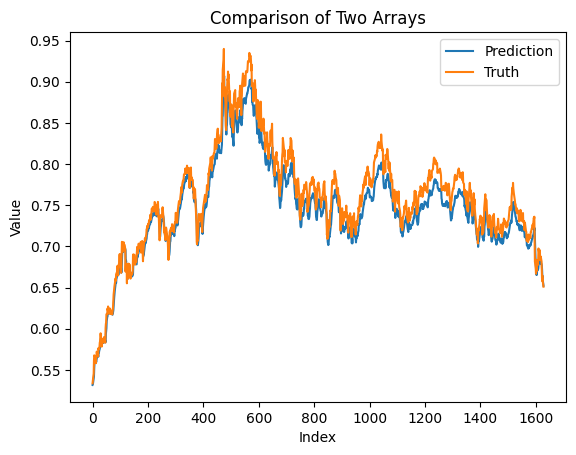

In [13]:
preds = model.predict(X_test)
print("MSE:", root_mean_squared_error(y_test, preds))

# Create index for x-axis
x = np.arange(len(preds))

plt.figure()

# Plot both arrays
plt.plot(x, preds, label="Prediction")
plt.plot(x, y_test, label="Truth")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MSE: 0.017952359693959842


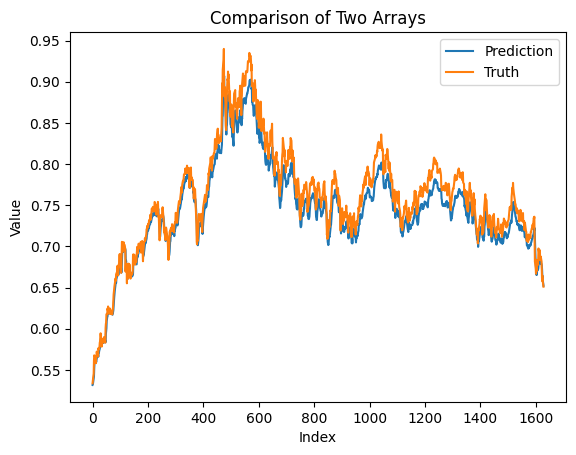

In [ ]:
preds = model.predict(X_test)
print("MSE:", root_mean_squared_error(y_test, preds))

# Create index for x-axis
x = np.arange(len(preds))

plt.figure()

# Plot both arrays
plt.plot(x, preds, label="Prediction")
plt.plot(x, y_test, label="Truth")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.009414082624686033


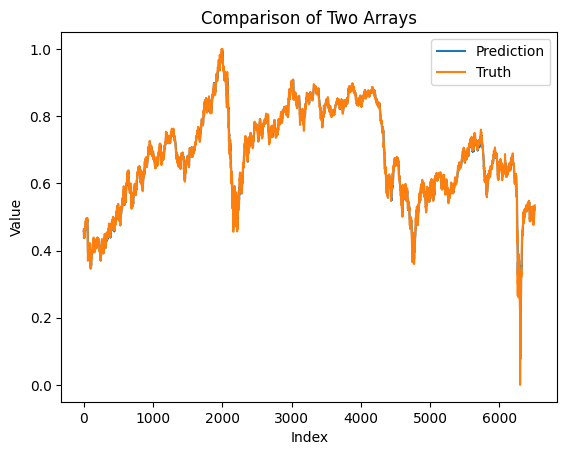

In [14]:
preds = model.predict(X_train)
print("MSE:", root_mean_squared_error(y_train, preds))

# Create index for x-axis
x = np.arange(len(preds))

plt.figure()

# Plot both arrays
plt.plot(x, preds, label="Prediction")
plt.plot(x, y_train, label="Truth")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()

